In [1]:
import scanpy as sc
import scarches as sca
import numpy as np
import pandas as pd
from scarches.plotting.terms_scores import plot_abs_bfs_key
import seaborn as sns
from scipy.stats import entropy, pearsonr

Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(6, 6))
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb

font = {'family' : 'Arial',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rcParams["figure.dpi"] = 200

### Pbmc Kang

In [3]:
adata = sc.read('kang_pbmc_integrated.h5ad')

In [4]:
adata.obs['condition_merged'] = adata.obs['condition'].tolist()
adata.obs['condition_merged'][adata.obs['condition_merged'].astype(str)=='nan'] = 'control'
adata.strings_to_categoricals()

<ipython-input-4-dcc145970c64>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['condition_merged'][adata.obs['condition_merged'].astype(str)=='nan'] = 'control'


In [5]:
intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nolog_alpha_kl_0_5_0_1_sd_2020', adata)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Cond layer in, ext, ext_m, cond, out and :  282 0 0 5 1972
	with hard mask.


In [6]:
dec_weights = intr_cvae.model.decoder.L0.expr_L.weight.data.cpu().numpy()

In [7]:
gpcr_gps = "SIGNALING_BY_GPCR", "GPCR_DOWNSTREAM_SIGNALING", "GPCR_LIGAND_BINDING"

In [8]:
gpcr_gps = list(gpcr_gps) + ['INTERFERON_ALPHA_BETA_SIGNALING', 'INTERFERON_SIGNALING', 'METABOLISM_OF_CARBOHYDRATES',
                             'METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 'MHC_CLASS_II_ANTIGEN_PRESENTATION',
                             'SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', 'PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION',
                             "TRAF6_MEDIATED_INDUCTION_OF_NFKB_AND_MAP_KINASES_UPON_TLR7_8_OR_9_ACTIVATION",
                             "TRANSLATION",
                             "MEIOTIC_SYNAPSIS"]

In [9]:
gpcr_table = pd.DataFrame(index=adata.var_names.tolist())

for gpcr_gp in gpcr_gps:
    gpcr_table[gpcr_gp] = dec_weights[:, adata.uns["full_terms"] == gpcr_gp]

In [10]:
gpcr_table.to_csv('GPCR_GPs.csv')

In [11]:
tables = []
for gpcr_gp in gpcr_gps:
    gpcr_gp_t = gpcr_table[[gpcr_gp]].copy()
    gpcr_gp_t.sort_values(by=gpcr_gp, ascending=False, key=abs, inplace=True)
    gpcr_gp_t = gpcr_gp_t.loc[gpcr_gp_t[gpcr_gp].abs() > 0.]
    gpcr_gp_t.to_csv(gpcr_gp + '.csv')
    
    tables.append(gpcr_gp_t)

In [12]:
adata.layers["counts"] = adata.X.copy()

In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

<AxesSubplot:xlabel='SIGNALING_BY_GPCR', ylabel='Count'>

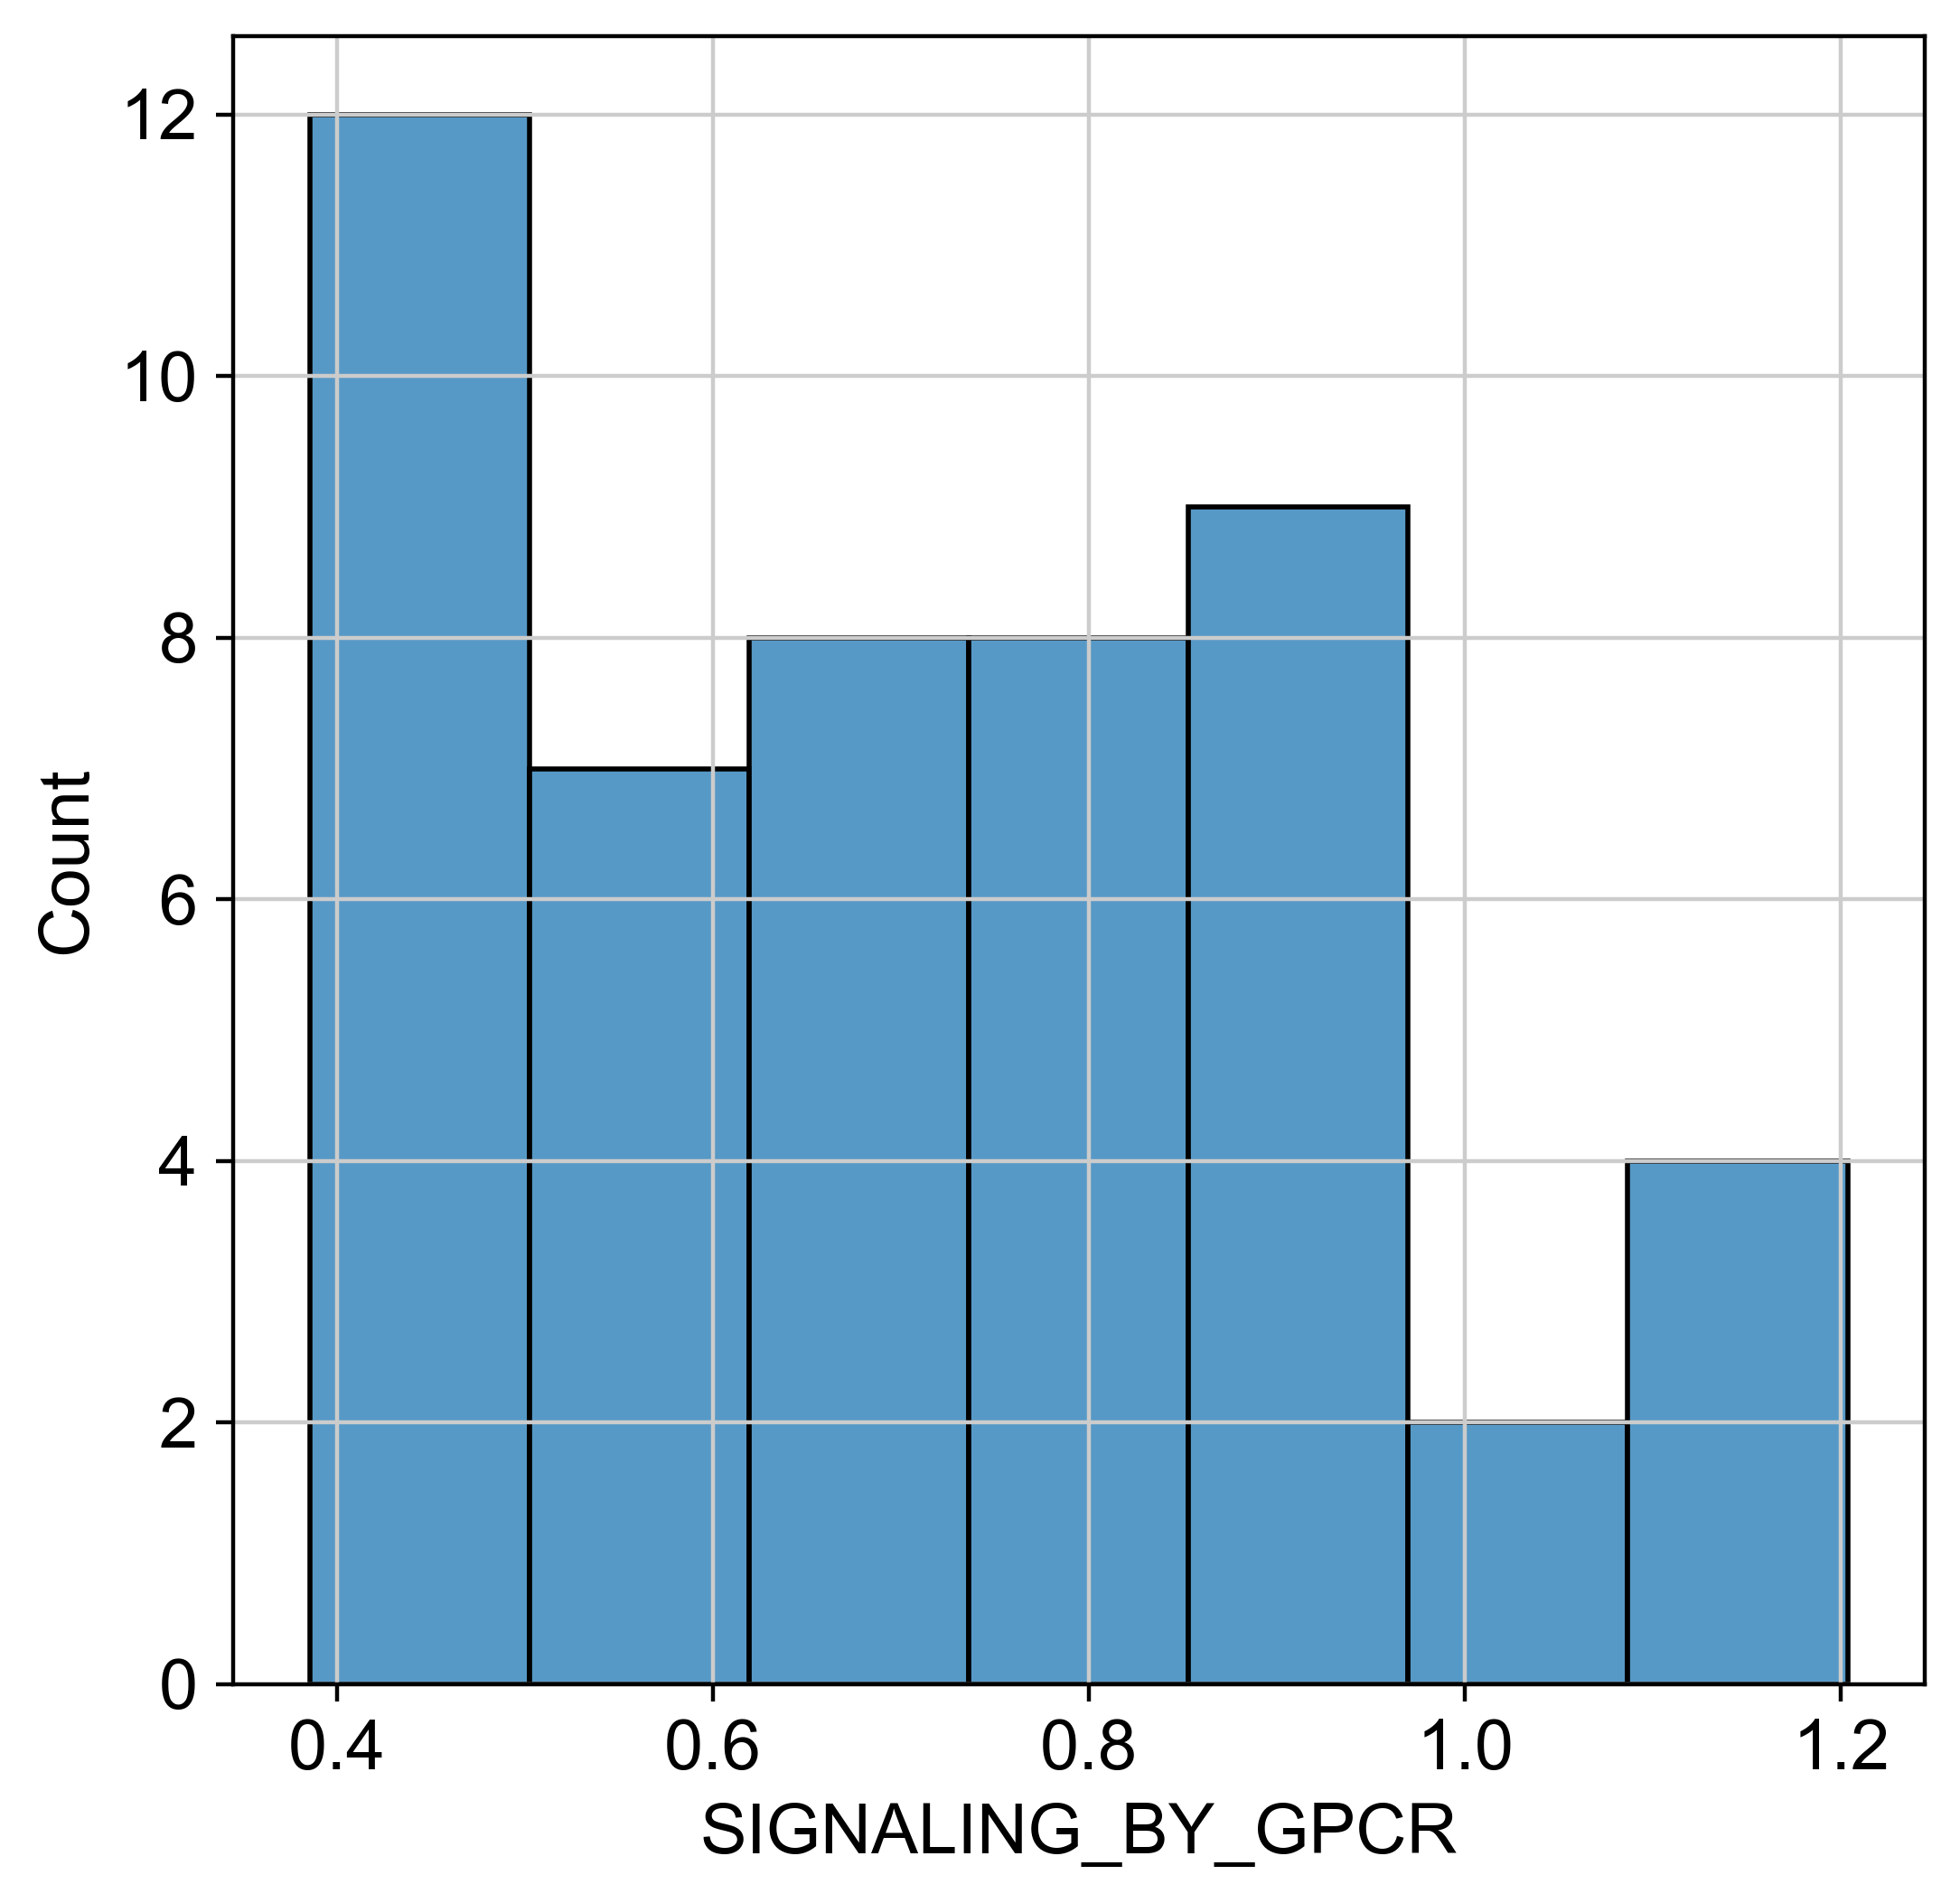

In [14]:
sns.histplot(x=tables[0].iloc[:50, 0].abs())

<AxesSubplot:xlabel='MHC_CLASS_II_ANTIGEN_PRESENTATION', ylabel='Count'>

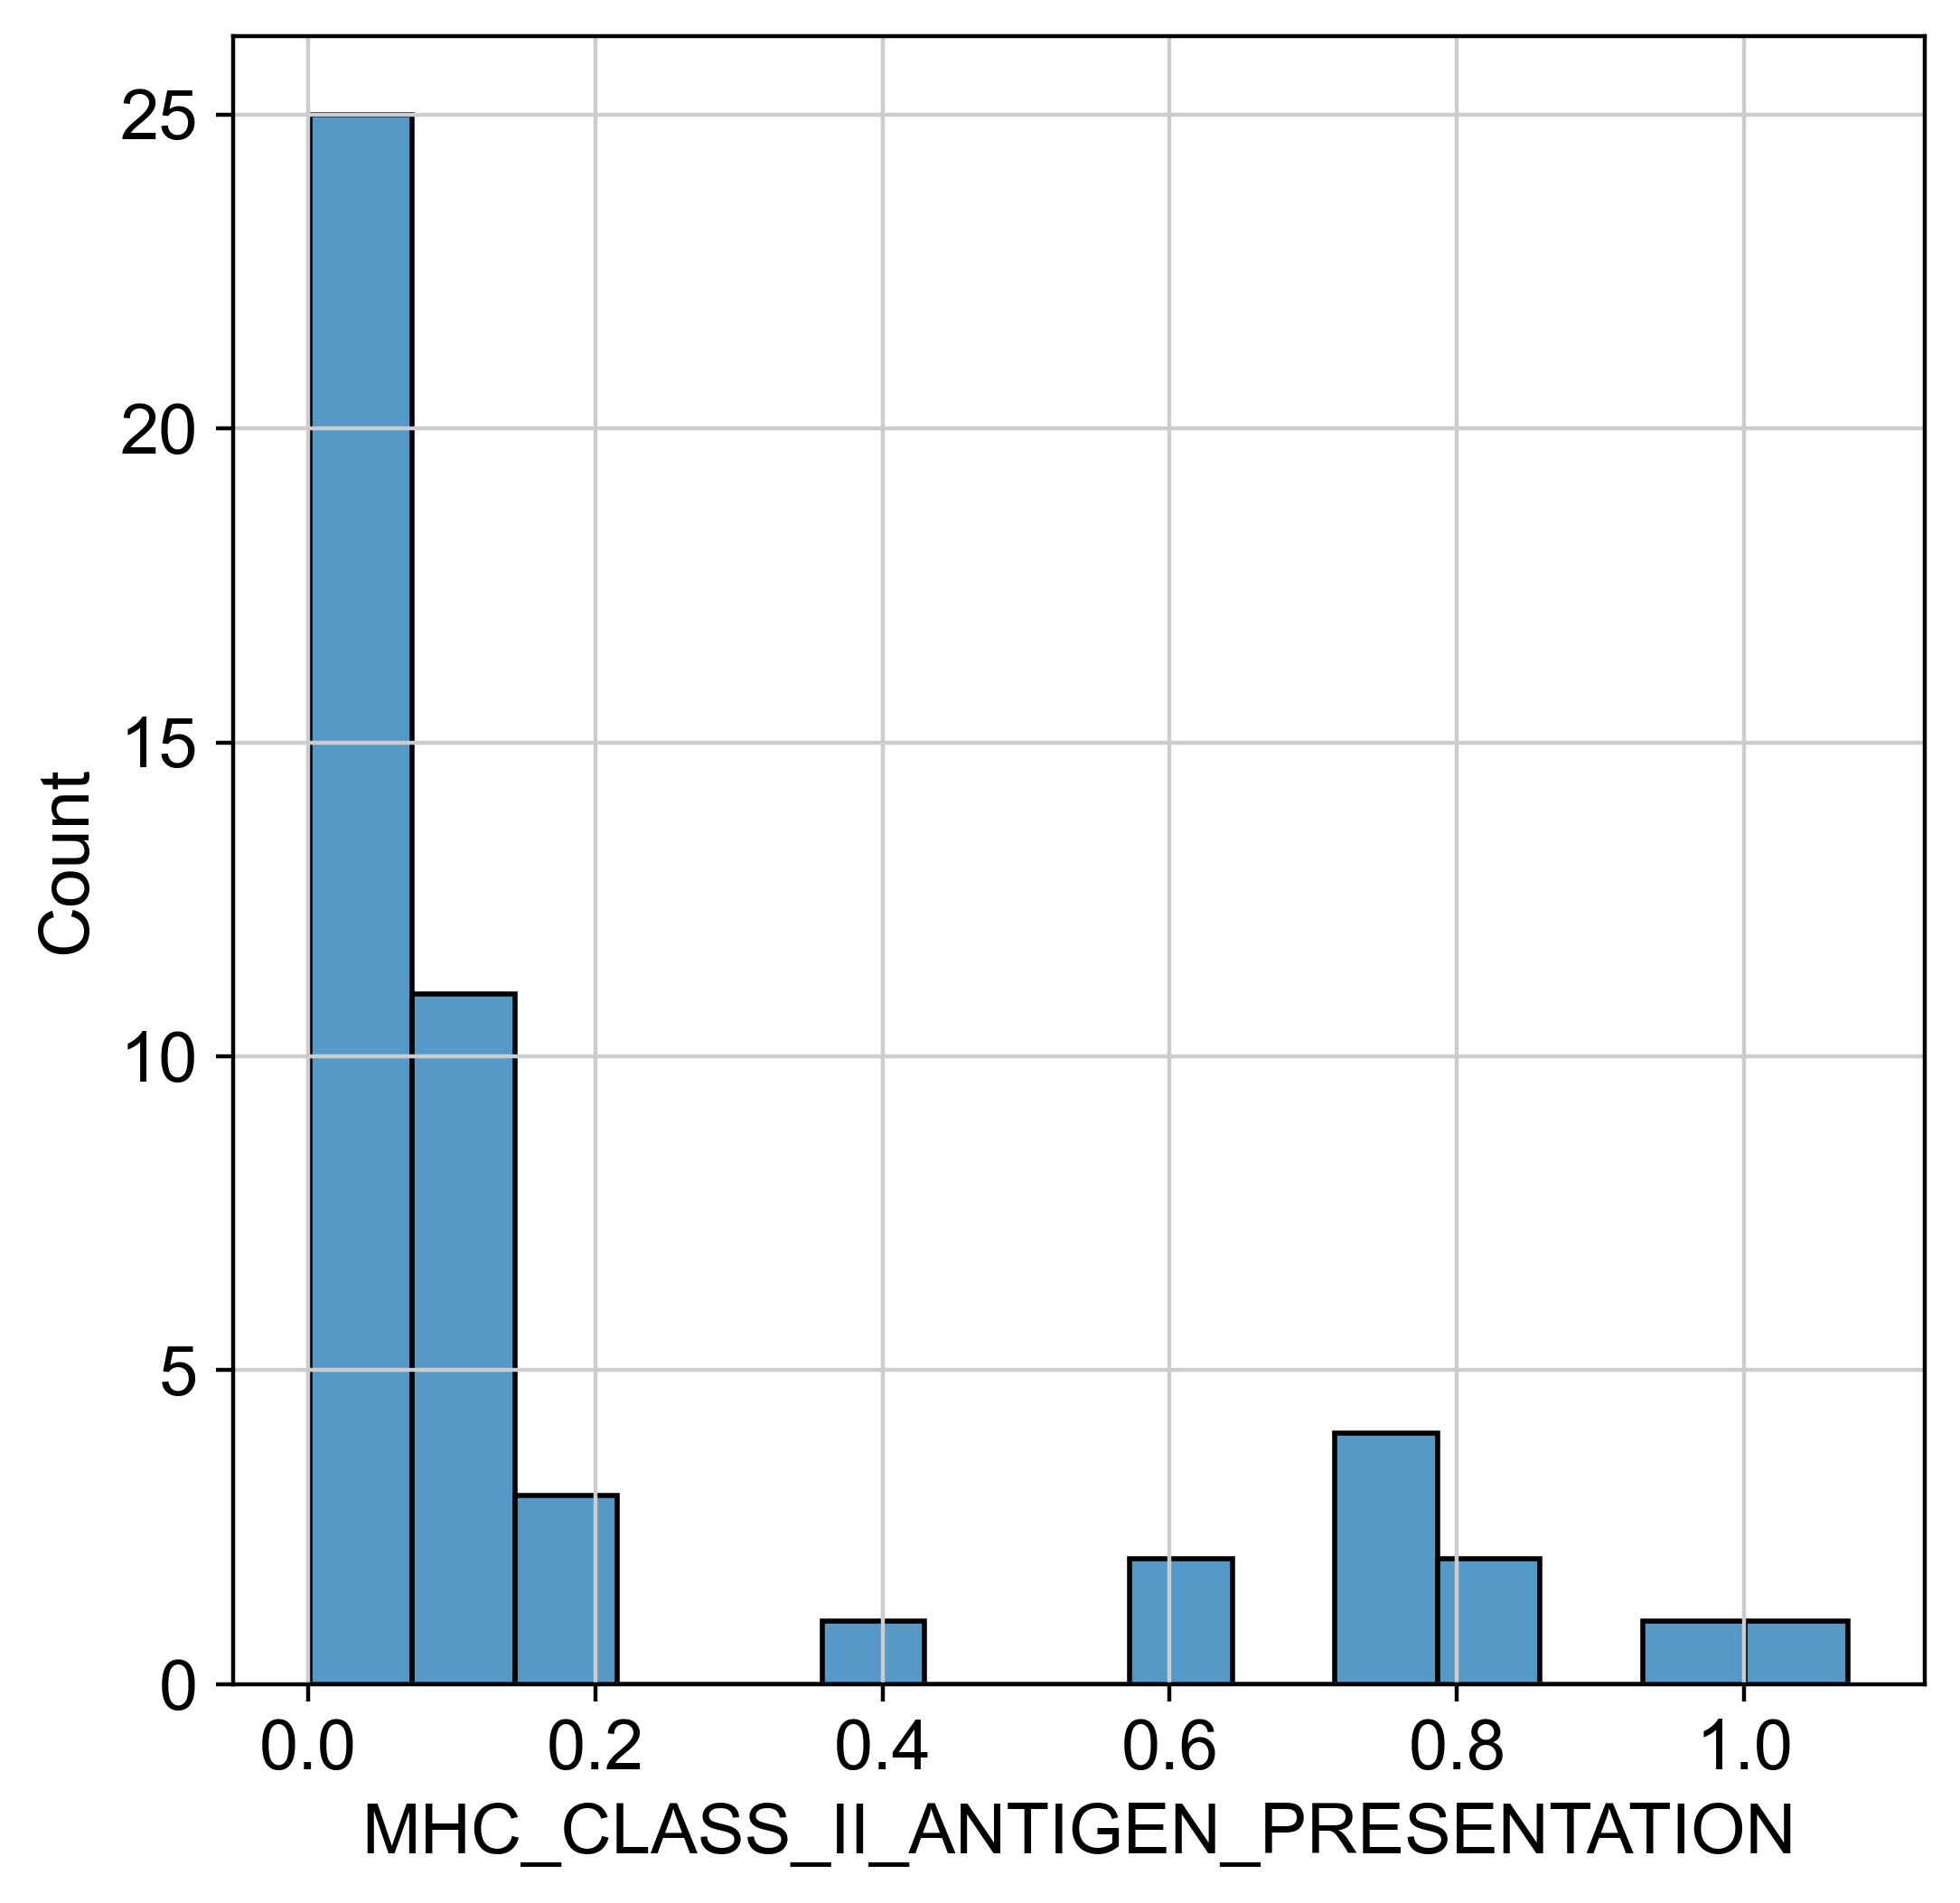

In [15]:
sns.histplot(x=tables[7].iloc[:50, 0].abs())

In [16]:
entropy_table = pd.DataFrame(index=adata.uns["full_terms"])

In [17]:
entropy_table["N_GENES"] = 0

In [18]:
entropy_table["NORMALIZED_ENTROPY"] = 0.

In [19]:
top = 50

In [20]:
for term in adata.uns["full_terms"]:
    term_weights = np.ravel(np.abs(dec_weights[:, adata.uns["full_terms"] == term]))
    sorted_idx = np.argsort(term_weights)[::-1]
    sorted_idx = sorted_idx[:top]
    top_weights = term_weights[sorted_idx]
    
    nnz = np.count_nonzero(top_weights)
    
    if nnz > 0:
        top_weights = top_weights[:nnz]
        top_weights = top_weights / top_weights.sum()
        max_entropy = entropy(pk=(np.ones(nnz) / nnz), base=2)
        rel_entropy_term = entropy(pk=top_weights, base=2) / max_entropy

        entropy_table.loc[term, "NORMALIZED_ENTROPY"] = rel_entropy_term
        entropy_table.loc[term, "N_GENES"] = nnz

In [21]:
entropy_table = entropy_table[entropy_table["N_GENES"] > 0]

In [22]:
entropy_table

,N_GENES,NORMALIZED_ENTROPY
TRANSLATION,41,0.908249
APOPTOTIC_CLEAVAGE_OF_CELLULAR_PROTEINS,18,0.892747
FORMATION_OF_THE_TERNARY_COMPLEX_AND_SUBSEQUENTLY_THE_43S_COMPLEX,15,0.958939
SIGNALING_BY_RHO_GTPASES,50,0.922047
SIGNALING_BY_WNT,18,0.942337
...,...,...
S_PHASE,32,0.914965
SIGNALING_BY_FGFR,50,0.939114
INTRINSIC_PATHWAY_FOR_APOPTOSIS,18,0.905226
PI3K_CASCADE,29,0.932156


<AxesSubplot:xlabel='NORMALIZED_ENTROPY'>

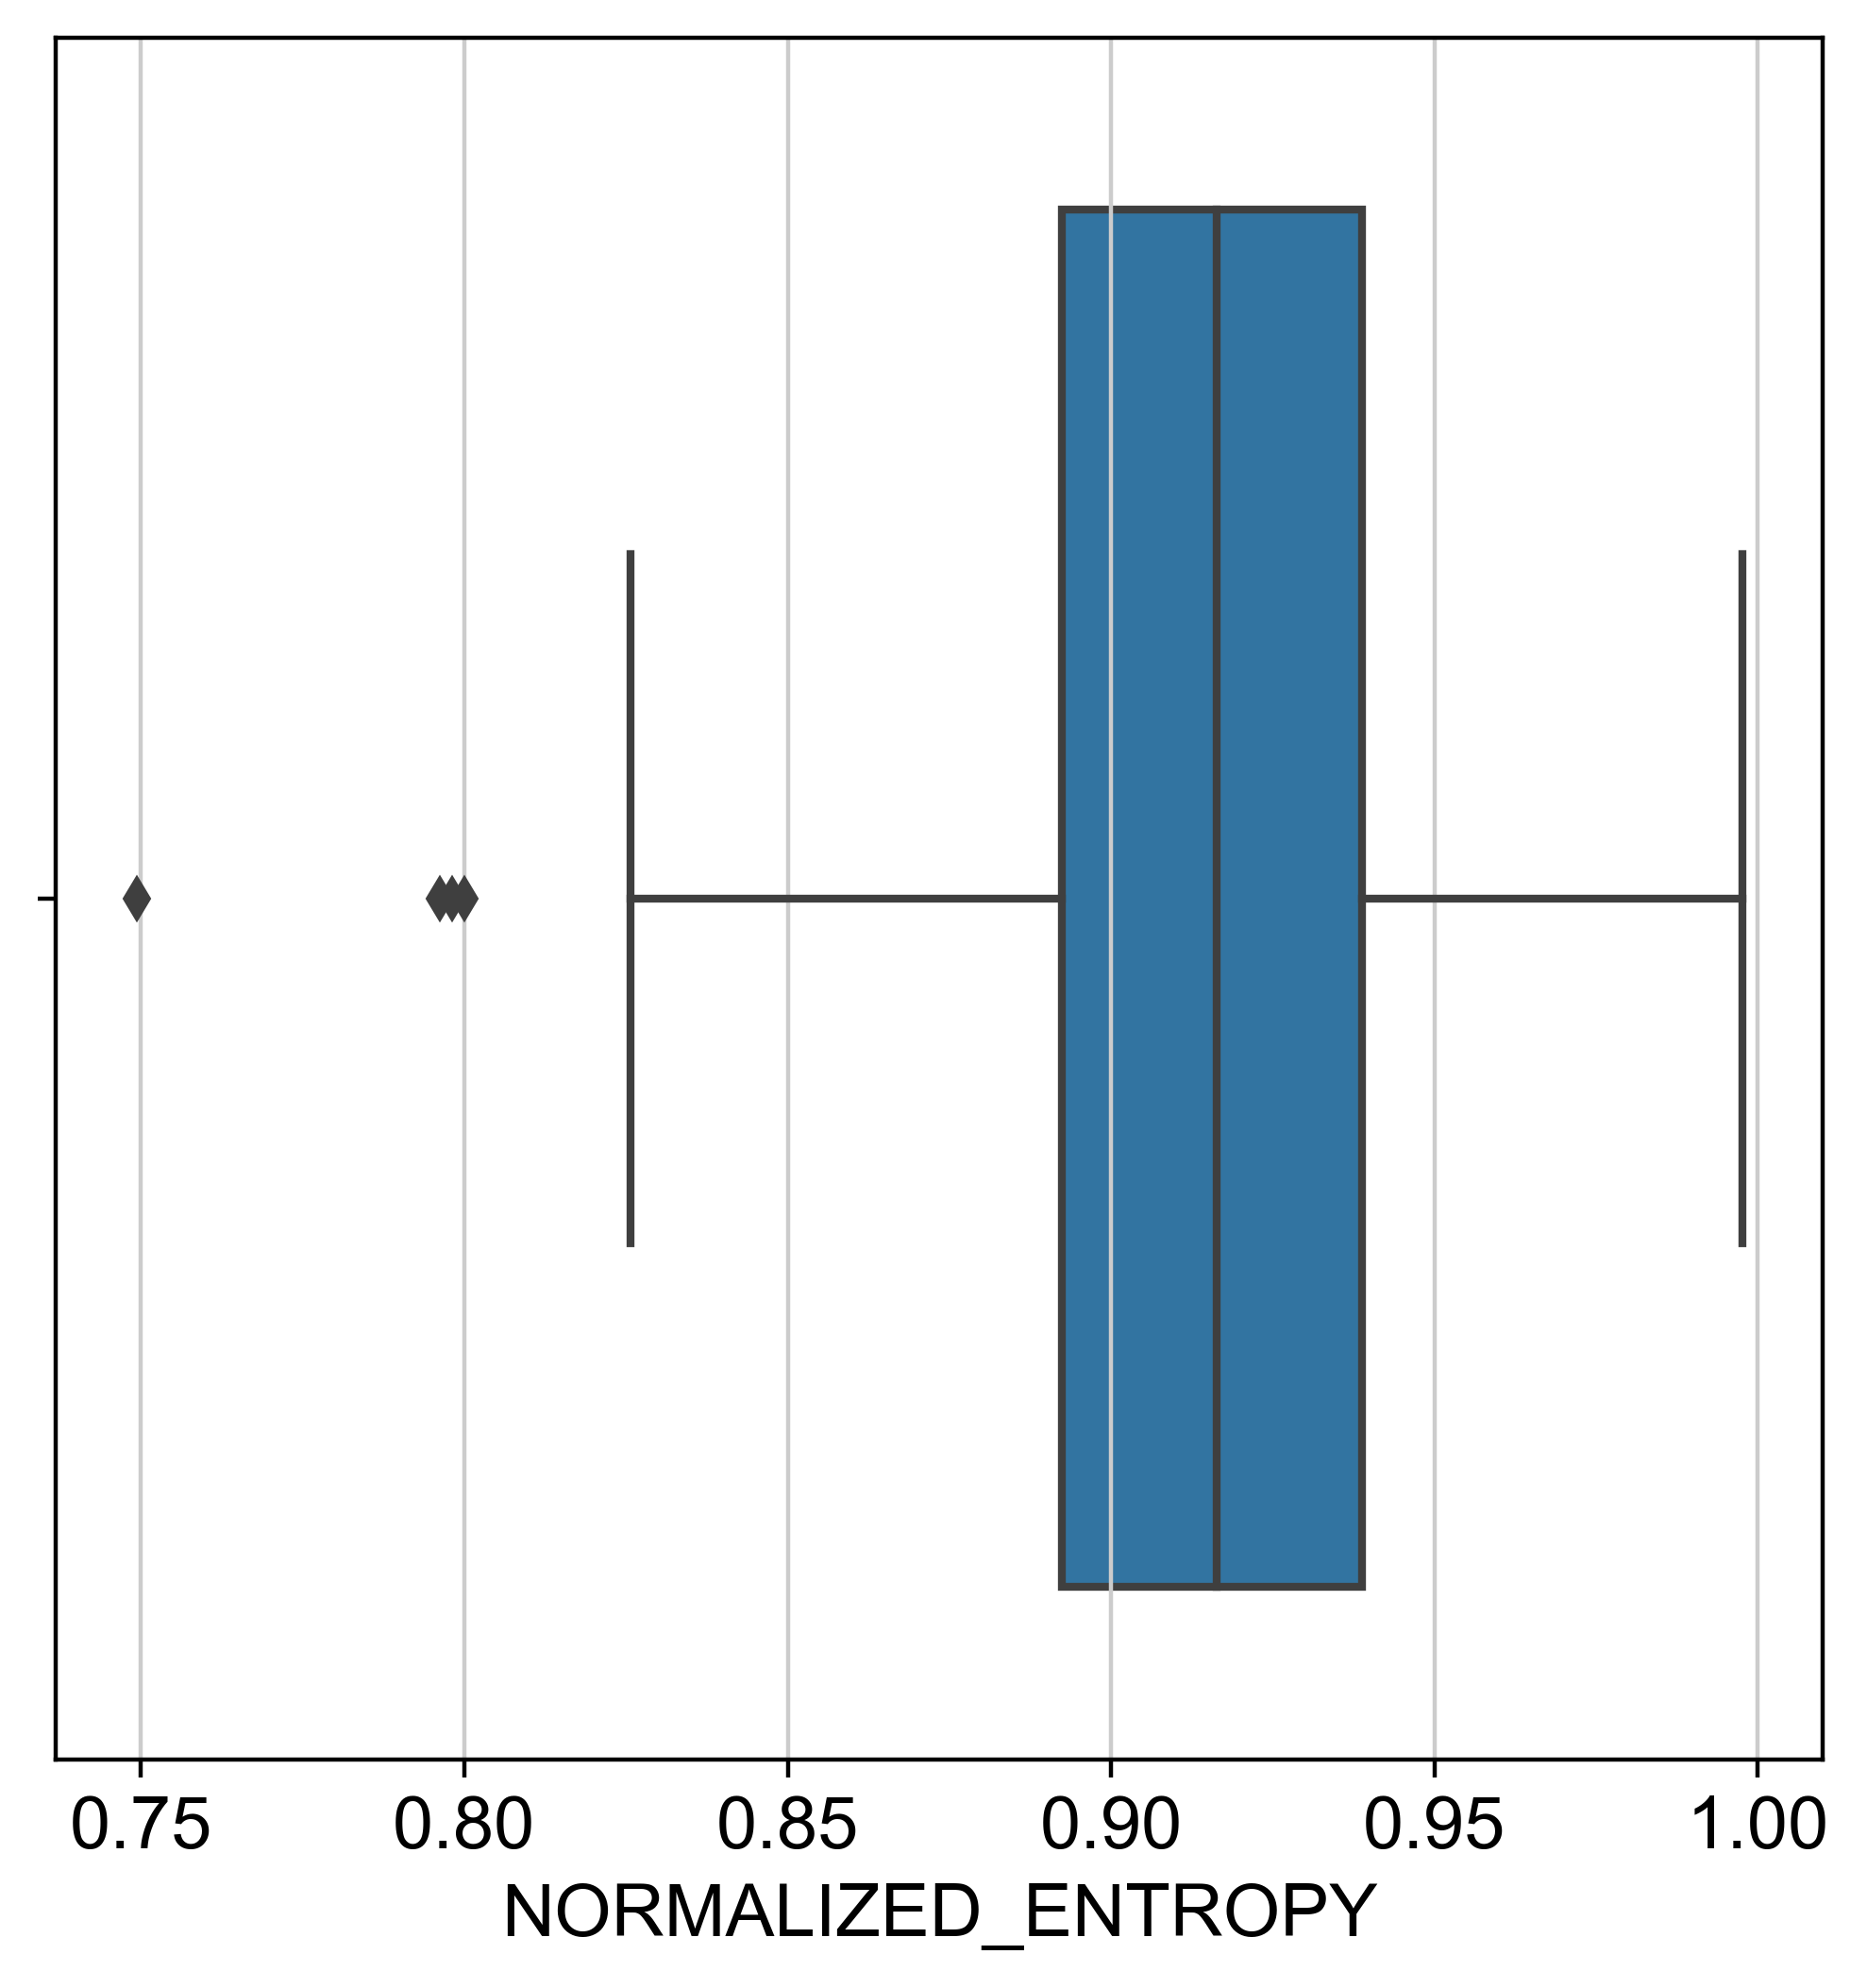

In [23]:
sns.boxplot(x=entropy_table.iloc[:, 1])

In [24]:
entropy_table.sort_values(by="NORMALIZED_ENTROPY")

,N_GENES,NORMALIZED_ENTROPY
RIG_I_MDA5_MEDIATED_INDUCTION_OF_IFN_ALPHA_BETA_PATHWAYS,42,0.749311
REGULATION_OF_MRNA_STABILITY_BY_PROTEINS_THAT_BIND_AU_RICH_ELEMENTS,25,0.796247
APOPTOTIC_EXECUTION_PHASE,24,0.798158
MHC_CLASS_II_ANTIGEN_PRESENTATION,50,0.799992
AMINO_ACID_AND_OLIGOPEPTIDE_SLC_TRANSPORTERS,17,0.825736
...,...,...
SIGNALING_BY_GPCR,50,0.988238
GENERIC_TRANSCRIPTION_PATHWAY,50,0.992392
METABOLISM_OF_PROTEINS,50,0.992482
ADAPTIVE_IMMUNE_SYSTEM,50,0.995166


In [39]:
to_check = ["SIGNALING_BY_GPCR", "GPCR_DOWNSTREAM_SIGNALING", "GPCR_LIGAND_BINDING", 'INTERFERON_ALPHA_BETA_SIGNALING', 
            'INTERFERON_SIGNALING', 'METABOLISM_OF_CARBOHYDRATES',
             'METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 'MHC_CLASS_II_ANTIGEN_PRESENTATION',
              'SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', 'PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION']

In [40]:
entropy_table.loc[to_check].sort_values(by="NORMALIZED_ENTROPY")

,N_GENES,NORMALIZED_ENTROPY
MHC_CLASS_II_ANTIGEN_PRESENTATION,50,0.799992
SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR,50,0.850434
INTERFERON_ALPHA_BETA_SIGNALING,45,0.900550
INTERFERON_SIGNALING,50,0.954564
GPCR_LIGAND_BINDING,50,0.956096
METABOLISM_OF_CARBOHYDRATES,50,0.962584
PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION,50,0.973743
METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS,50,0.979444
GPCR_DOWNSTREAM_SIGNALING,50,0.986675
SIGNALING_BY_GPCR,50,0.988238


In [27]:
top = 20

term_table = pd.DataFrame(index=adata.var_names.tolist())

for term in to_check:
    term_table[term] = dec_weights[:, adata.uns["full_terms"] == term]

for term in to_check:
    term_table_t = term_table[[term]].copy()
    term_table_t.sort_values(by=term, ascending=False, key=abs, inplace=True)
    term_table_t = term_table_t.loc[term_table_t[term].abs() > 0.]
    
    corr = pearsonr(x=adata[:, term_table_t.iloc[:top, 0].index].X.mean(0), y=term_table_t.iloc[:top, 0].abs())[0]
    
    print(term, corr)

SIGNALING_BY_GPCR 0.5775388845443036
GPCR_DOWNSTREAM_SIGNALING -0.14471492726568666
GPCR_LIGAND_BINDING 0.46868738115224917
INTERFERON_ALPHA_BETA_SIGNALING 0.44436335378081326
INTERFERON_SIGNALING 0.5552243247624237
METABOLISM_OF_CARBOHYDRATES 0.2678305684554339
METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS -0.13745405086763013
MHC_CLASS_II_ANTIGEN_PRESENTATION 0.3860219366691391
SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR 0.138621921663447
PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION 0.2600127645654572
TRAF6_MEDIATED_INDUCTION_OF_NFKB_AND_MAP_KINASES_UPON_TLR7_8_OR_9_ACTIVATION 0.9102134585952628
TRANSLATION -0.5859715603939242
MEIOTIC_SYNAPSIS -0.00878608298365914


In [28]:
corrs_dict = {}
names = []

In [29]:
tops = [5, 10, 20, 50, 100]

term_table = pd.DataFrame(index=adata.var_names.tolist())

for term in adata.uns["full_terms"]:
    term_table[term] = dec_weights[:, adata.uns["full_terms"] == term]

for top in tops:
    print(top)
    corrs_dict[str(top)] = []
    for term in adata.uns["full_terms"]:
        term_table_t = term_table[[term]].copy()
        term_table_t.sort_values(by=term, ascending=False, key=abs, inplace=True)
        term_table_t = term_table_t.loc[term_table_t[term].abs() > 0.]

        if len(term_table_t) < 2:
            continue

        corr = pearsonr(x=adata[:, term_table_t.iloc[:top, 0].index].X.mean(0), y=term_table_t.iloc[:top, 0].abs())[0]

        corrs_dict[str(top)].append(corr)
        
        if term not in names:
            names.append(term)

5
10
20
50
100


In [30]:
corrs_df = pd.DataFrame(corrs_dict, index=names)

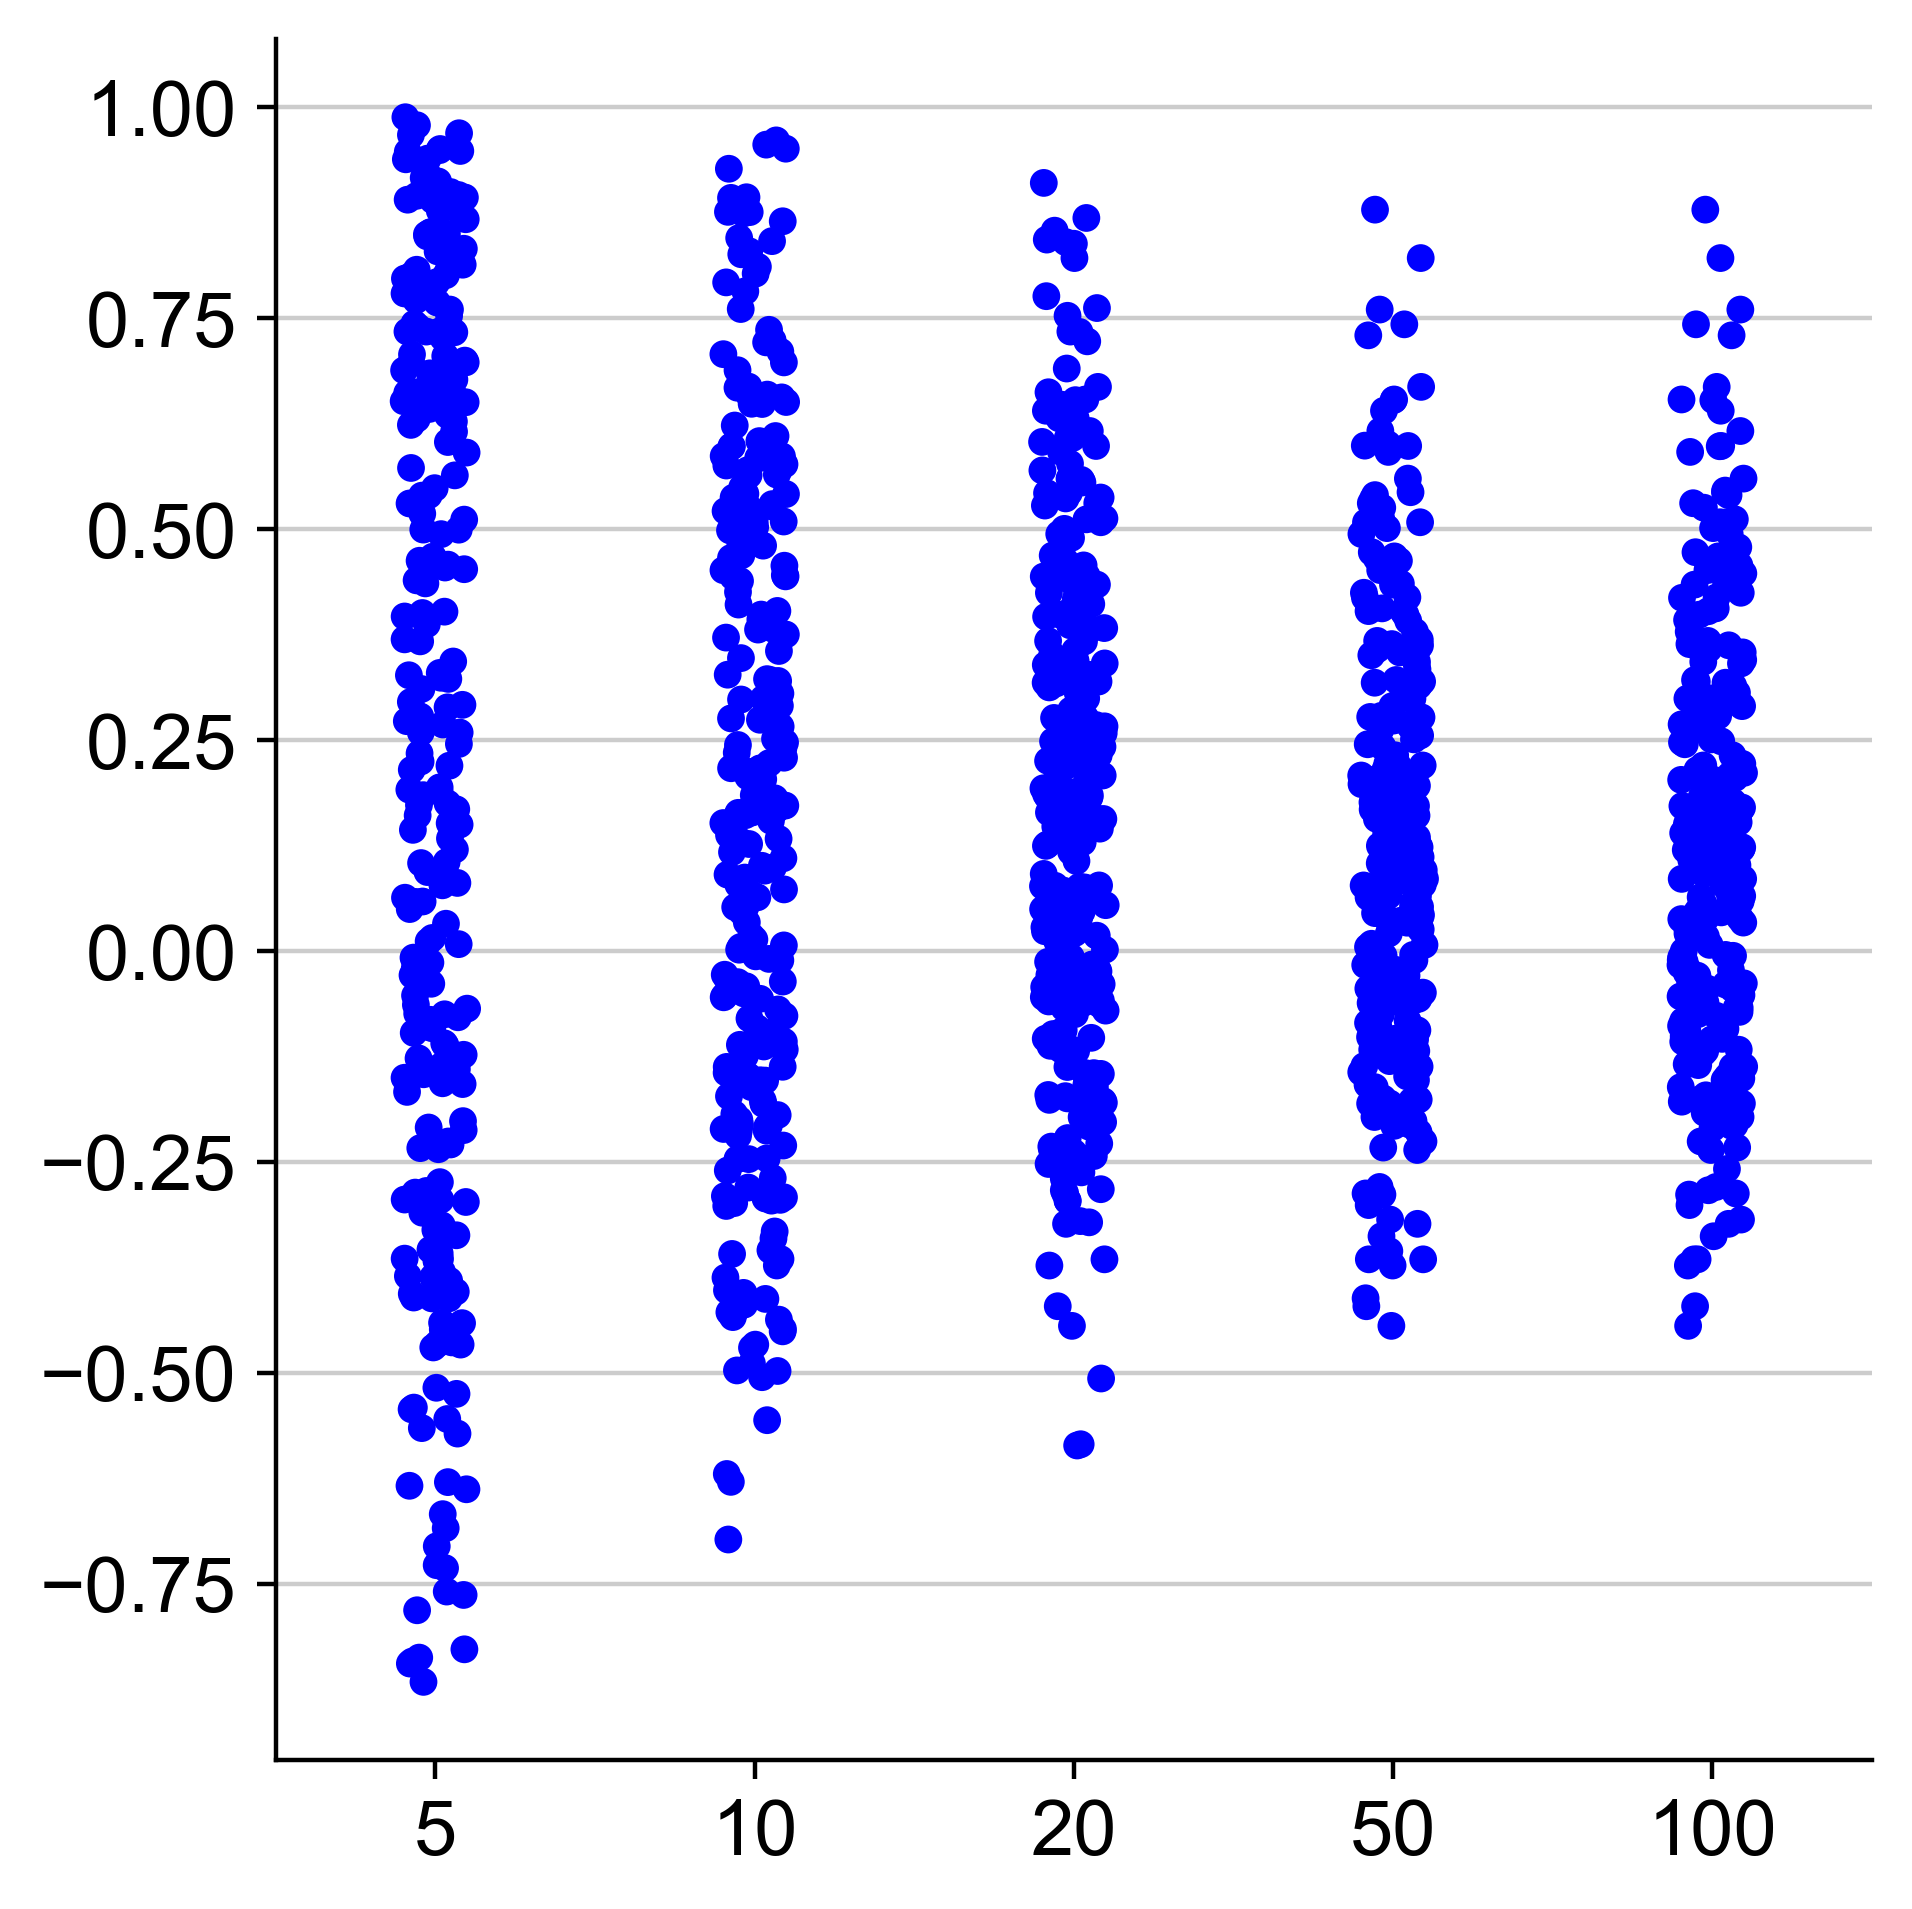

In [31]:
sns.catplot(data=corrs_df, color="blue")

In [32]:
corrs_df.sort_values(by="20", ascending=False).iloc[:20]

,5,10,20,50,100
TRAF6_MEDIATED_INDUCTION_OF_NFKB_AND_MAP_KINASES_UPON_TLR7_8_OR_9_ACTIVATION,0.760136,0.875609,0.910213,0.878529,0.878529
CLASS_A1_RHODOPSIN_LIKE_RECEPTORS,0.916276,0.893207,0.868668,0.402815,0.248473
SIGNALING_BY_TGF_BETA_RECEPTOR_COMPLEX,0.969059,0.960584,0.853604,0.729586,0.729586
PEPTIDE_LIGAND_BINDING_RECEPTORS,0.813305,0.844917,0.843054,0.353872,0.353872
AMYLOIDS,0.889620,0.892471,0.839948,-0.058926,-0.058926
NUCLEOTIDE_BINDING_DOMAIN_LEUCINE_RICH_REPEAT_CONTAINING_RECEPTOR_NLR_SIGNALING_PATHWAYS,0.846850,0.829209,0.838115,0.760122,0.760122
LATENT_INFECTION_OF_HOMO_SAPIENS_WITH_MYCOBACTERIUM_TUBERCULOSIS,0.807305,0.841225,0.821151,0.821151,0.821151
PLATELET_HOMEOSTASIS,0.988041,0.950770,0.775986,0.402641,0.402641
TRIF_MEDIATED_TLR3_SIGNALING,0.949048,0.825665,0.761916,0.467634,0.467634
SIGNALING_BY_RHO_GTPASES,0.911959,0.781810,0.752745,0.083404,-0.069732


In [33]:
corrs_df.sort_values(by="20", ascending=True).iloc[:20]

,5,10,20,50,100
TRANSLATION,-0.234851,-0.193265,-0.585972,-0.365362,-0.365362
METABOLISM_OF_PROTEINS,-0.411673,-0.629058,-0.584493,0.391189,0.598156
ADAPTIVE_IMMUNE_SYSTEM,-0.781231,-0.450698,-0.506580,-0.411515,-0.210025
G1_PHASE,0.699623,-0.113123,-0.444208,-0.444208,-0.444208
SIGNALING_BY_WNT,-0.013687,-0.137173,-0.420948,-0.420948,-0.420948
INTRINSIC_PATHWAY_FOR_APOPTOSIS,-0.390519,-0.153195,-0.372714,-0.372714,-0.372714
RNA_POL_II_PRE_TRANSCRIPTION_EVENTS,-0.078516,-0.402098,-0.365360,-0.365360,-0.365360
RNA_POL_II_TRANSCRIPTION_PRE_INITIATION_AND_PROMOTER_OPENING,-0.837335,-0.290438,-0.323293,-0.323293,-0.323293
IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,0.153582,-0.269203,-0.321512,-0.338028,-0.338028
PHOSPHOLIPID_METABOLISM,-0.866089,-0.497036,-0.320065,-0.085150,0.022717


In [34]:
corrs_df.sort_values(by="20", ascending=True, key=abs).iloc[:20]

,5,10,20,50,100
NONSENSE_MEDIATED_DECAY_ENHANCED_BY_THE_EXON_JUNCTION_COMPLEX,0.063151,-0.032373,0.001543,0.085574,0.085574
FORMATION_OF_THE_TERNARY_COMPLEX_AND_SUBSEQUENTLY_THE_43S_COMPLEX,-0.325122,0.184679,-0.007315,-0.007315,-0.007315
MEIOTIC_SYNAPSIS,0.234174,-0.076897,-0.008786,0.066642,0.066642
GPVI_MEDIATED_ACTIVATION_CASCADE,-0.273906,-0.091140,-0.009808,-0.038501,-0.038501
G_ALPHA_S_SIGNALLING_EVENTS,0.662871,0.251385,0.011044,-0.137030,-0.137030
MITOTIC_M_M_G1_PHASES,-0.571835,-0.172122,-0.012794,0.160492,0.160492
SIGNALING_BY_INSULIN_RECEPTOR,-0.759046,-0.428103,-0.015126,-0.191801,-0.191801
GLYCOSAMINOGLYCAN_METABOLISM,-0.731279,-0.260042,-0.015903,0.247316,0.247316
REGULATION_OF_APOPTOSIS,0.734028,-0.154844,-0.016569,-0.016569,-0.016569
RNA_POL_I_RNA_POL_III_AND_MITOCHONDRIAL_TRANSCRIPTION,0.603156,-0.246562,0.018150,-0.121445,-0.121445


<AxesSubplot:ylabel='TRAF6_MEDIATED_INDUCTION_OF_NFKB_AND_MAP_KINASES_UPON_TLR7_8_OR_9_ACTIVATION'>

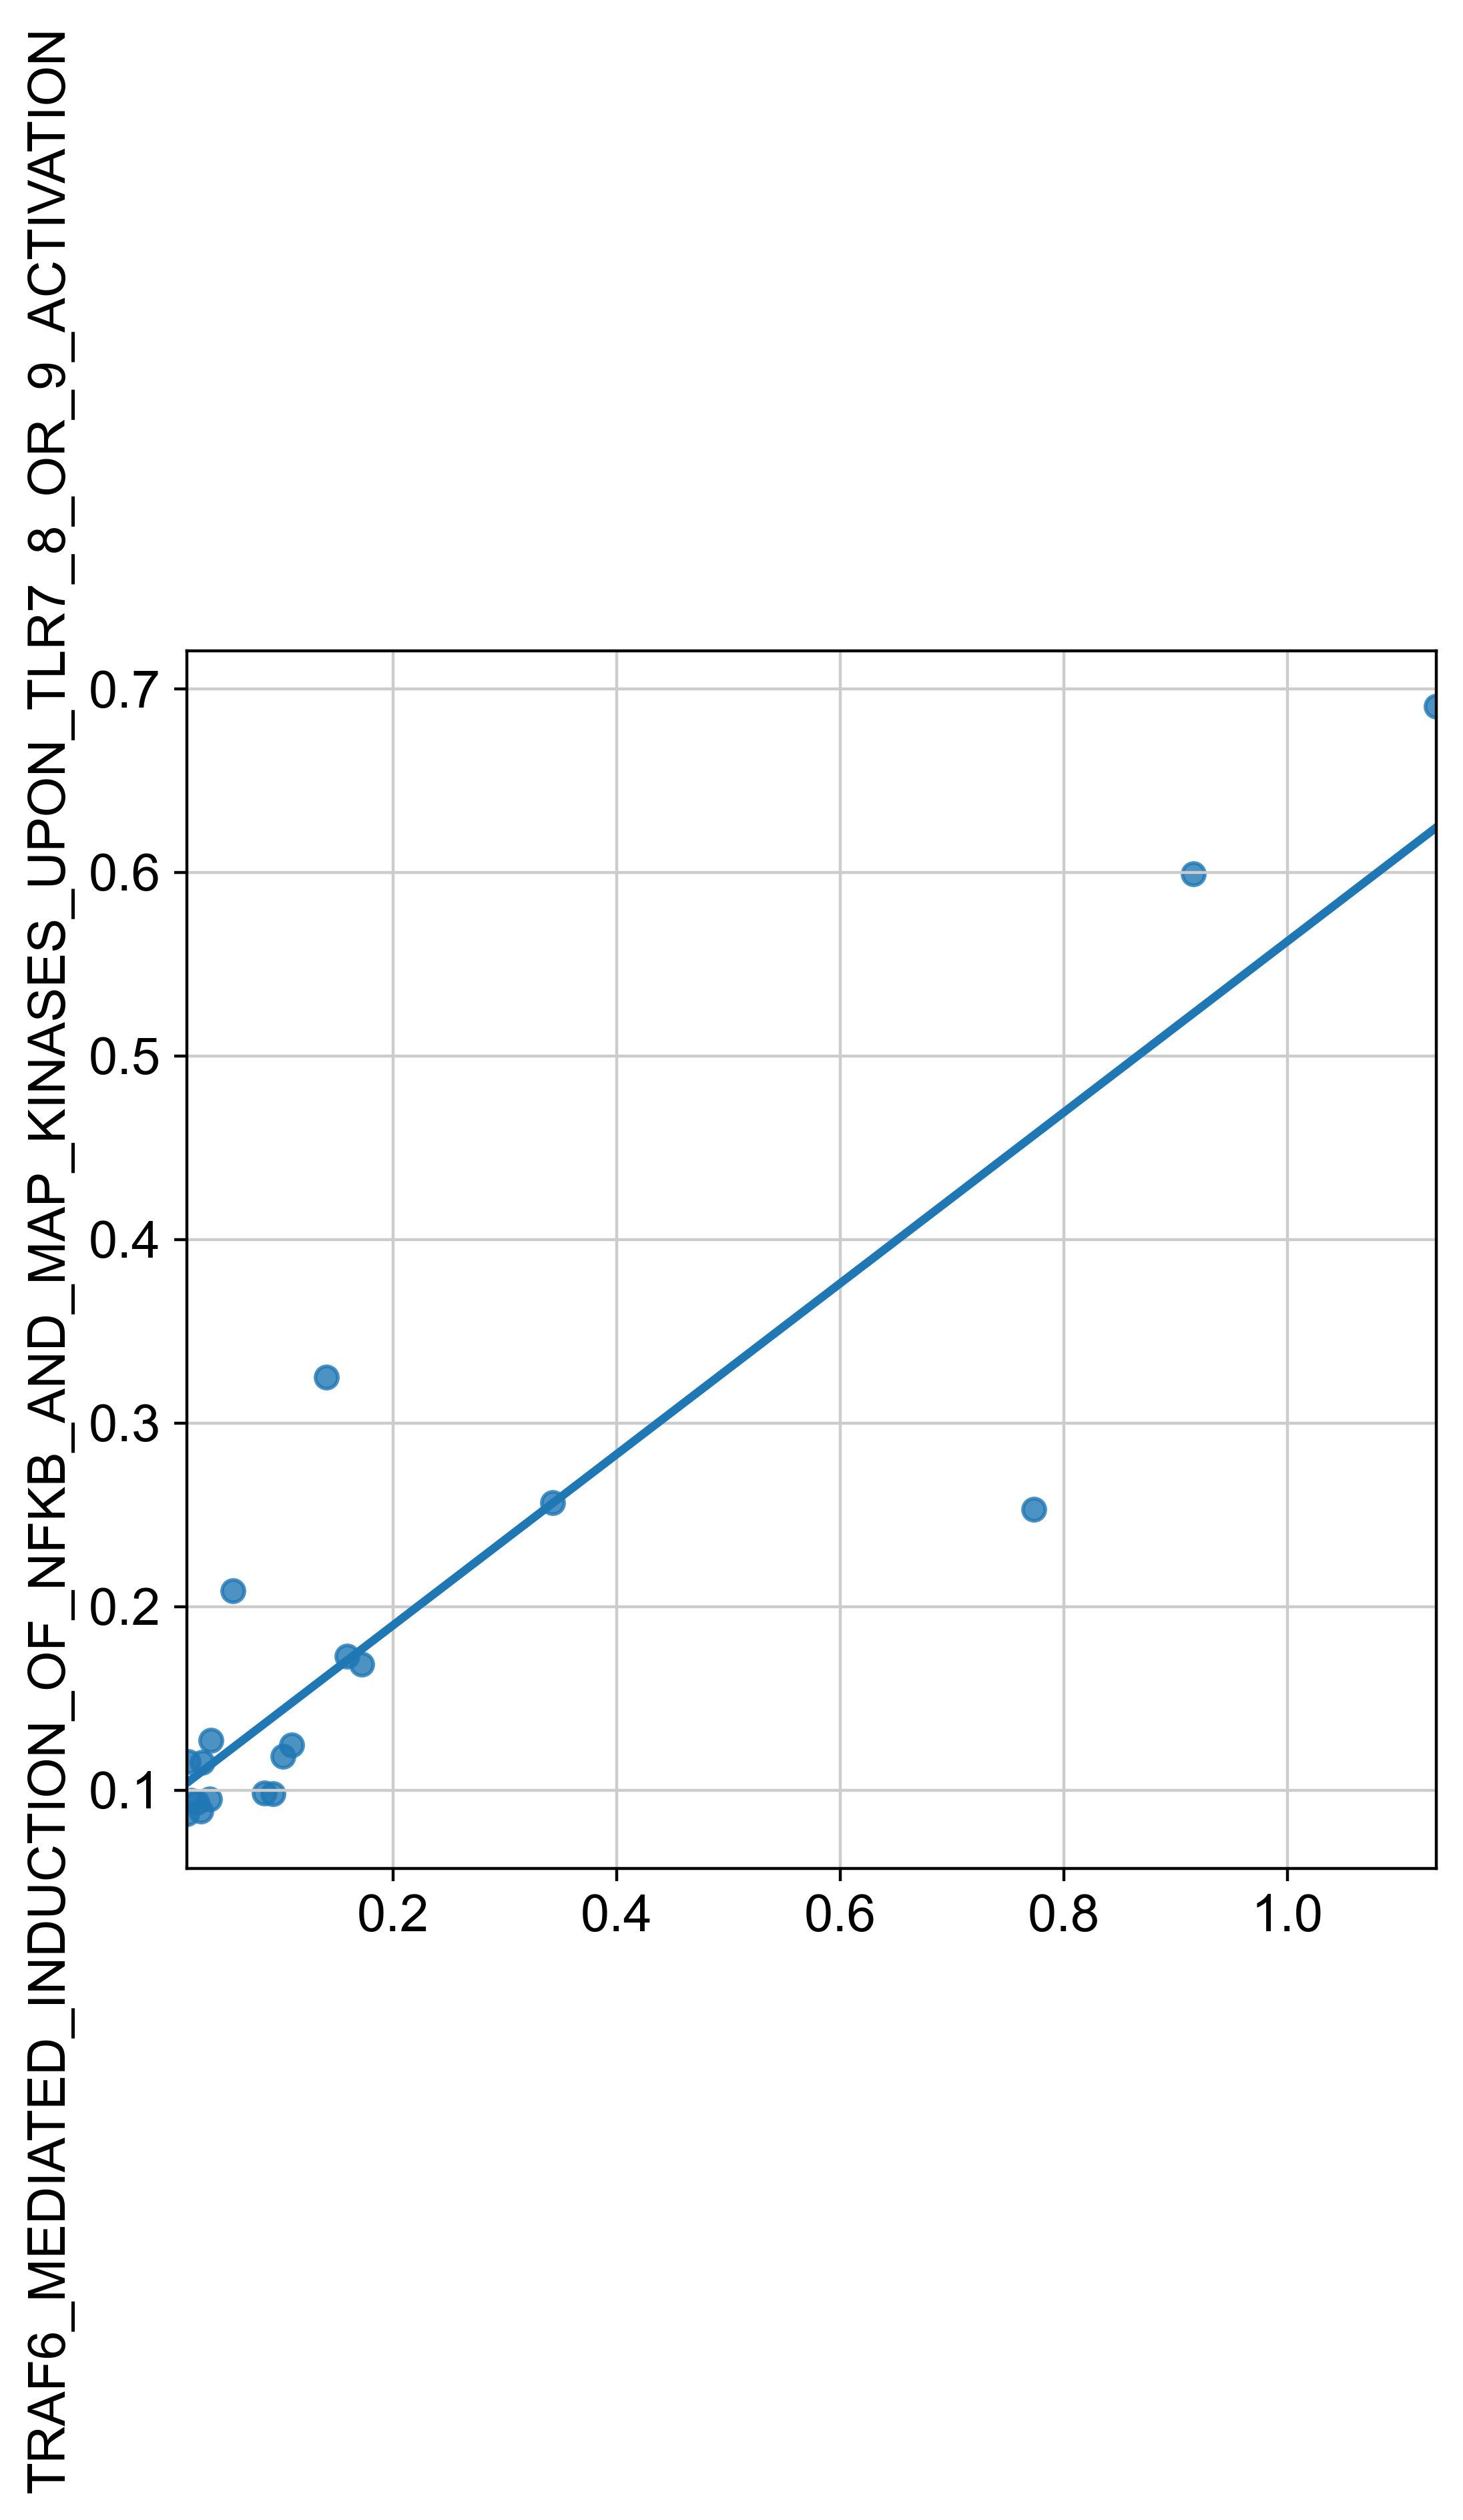

In [35]:
x = np.array(adata[:, tables[10].iloc[:20, 0].index].X.mean(0))
sns.regplot(x=x, y=tables[10].iloc[:20, 0].abs(), ci=None)

<AxesSubplot:ylabel='TRANSLATION'>

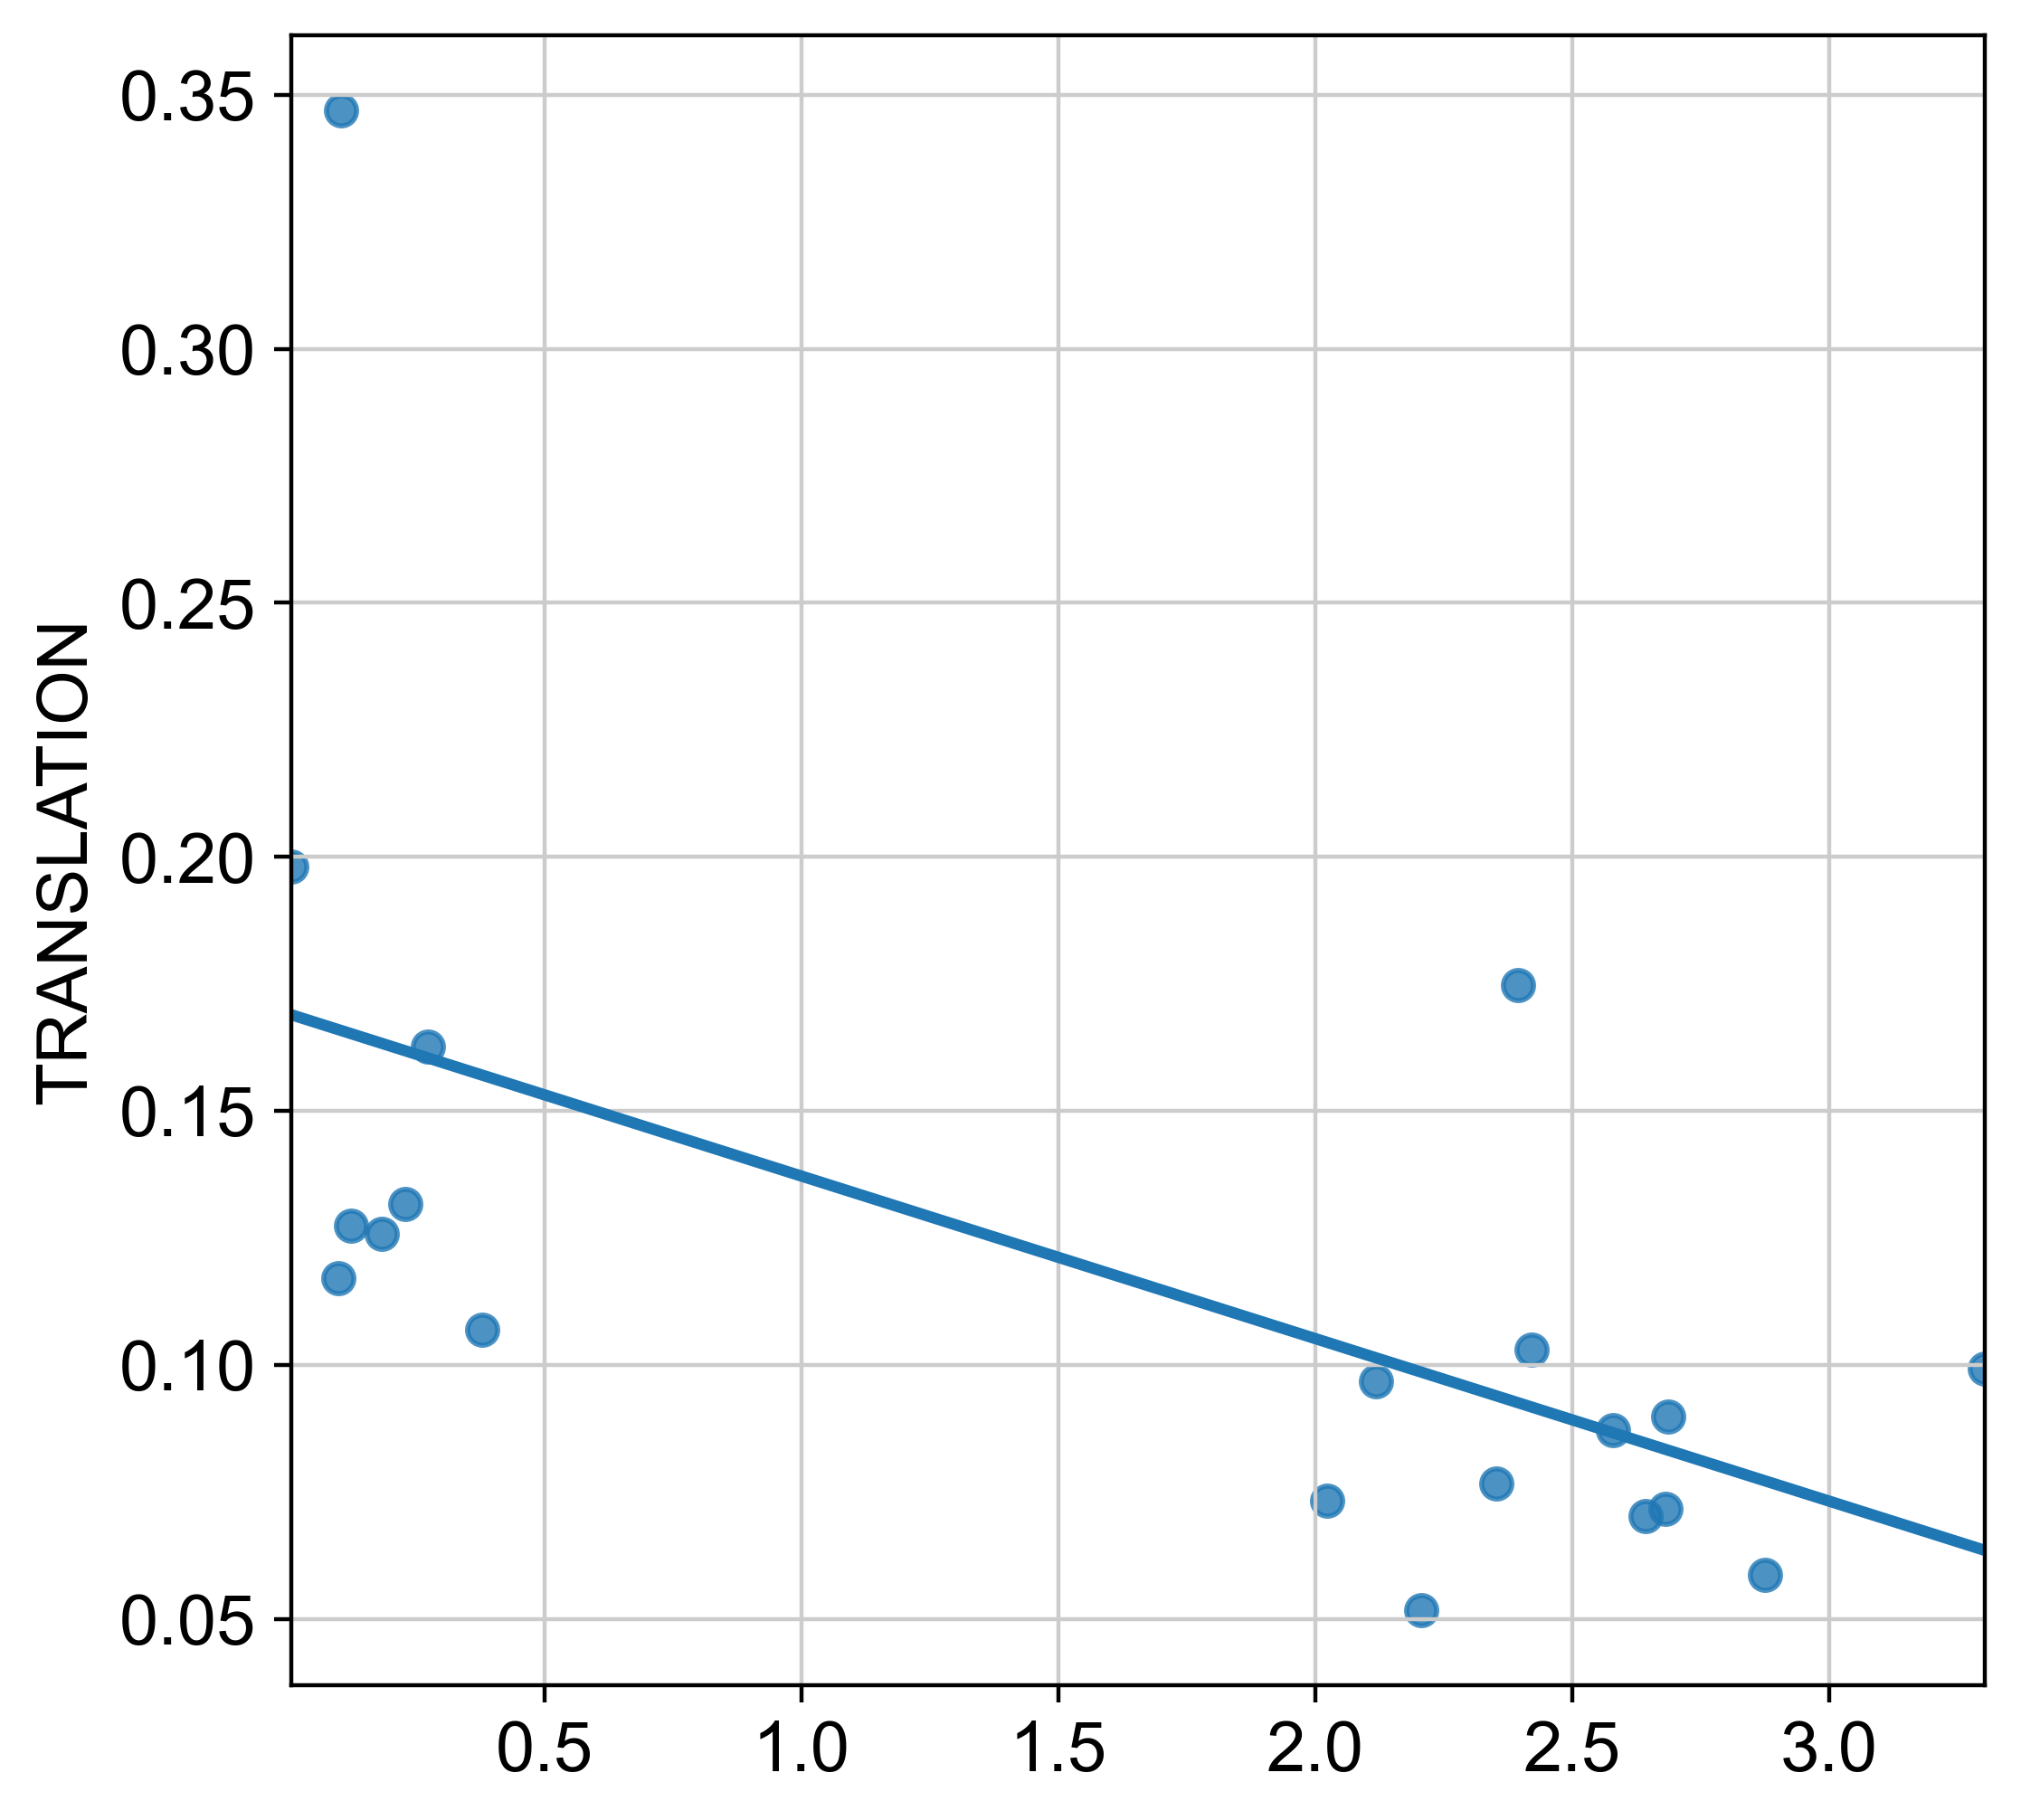

In [36]:
x = np.array(adata[:, tables[11].iloc[:20, 0].index].X.mean(0))
sns.regplot(x=x, y=tables[11].iloc[:20, 0].abs(), ci=None)

<AxesSubplot:ylabel='MEIOTIC_SYNAPSIS'>

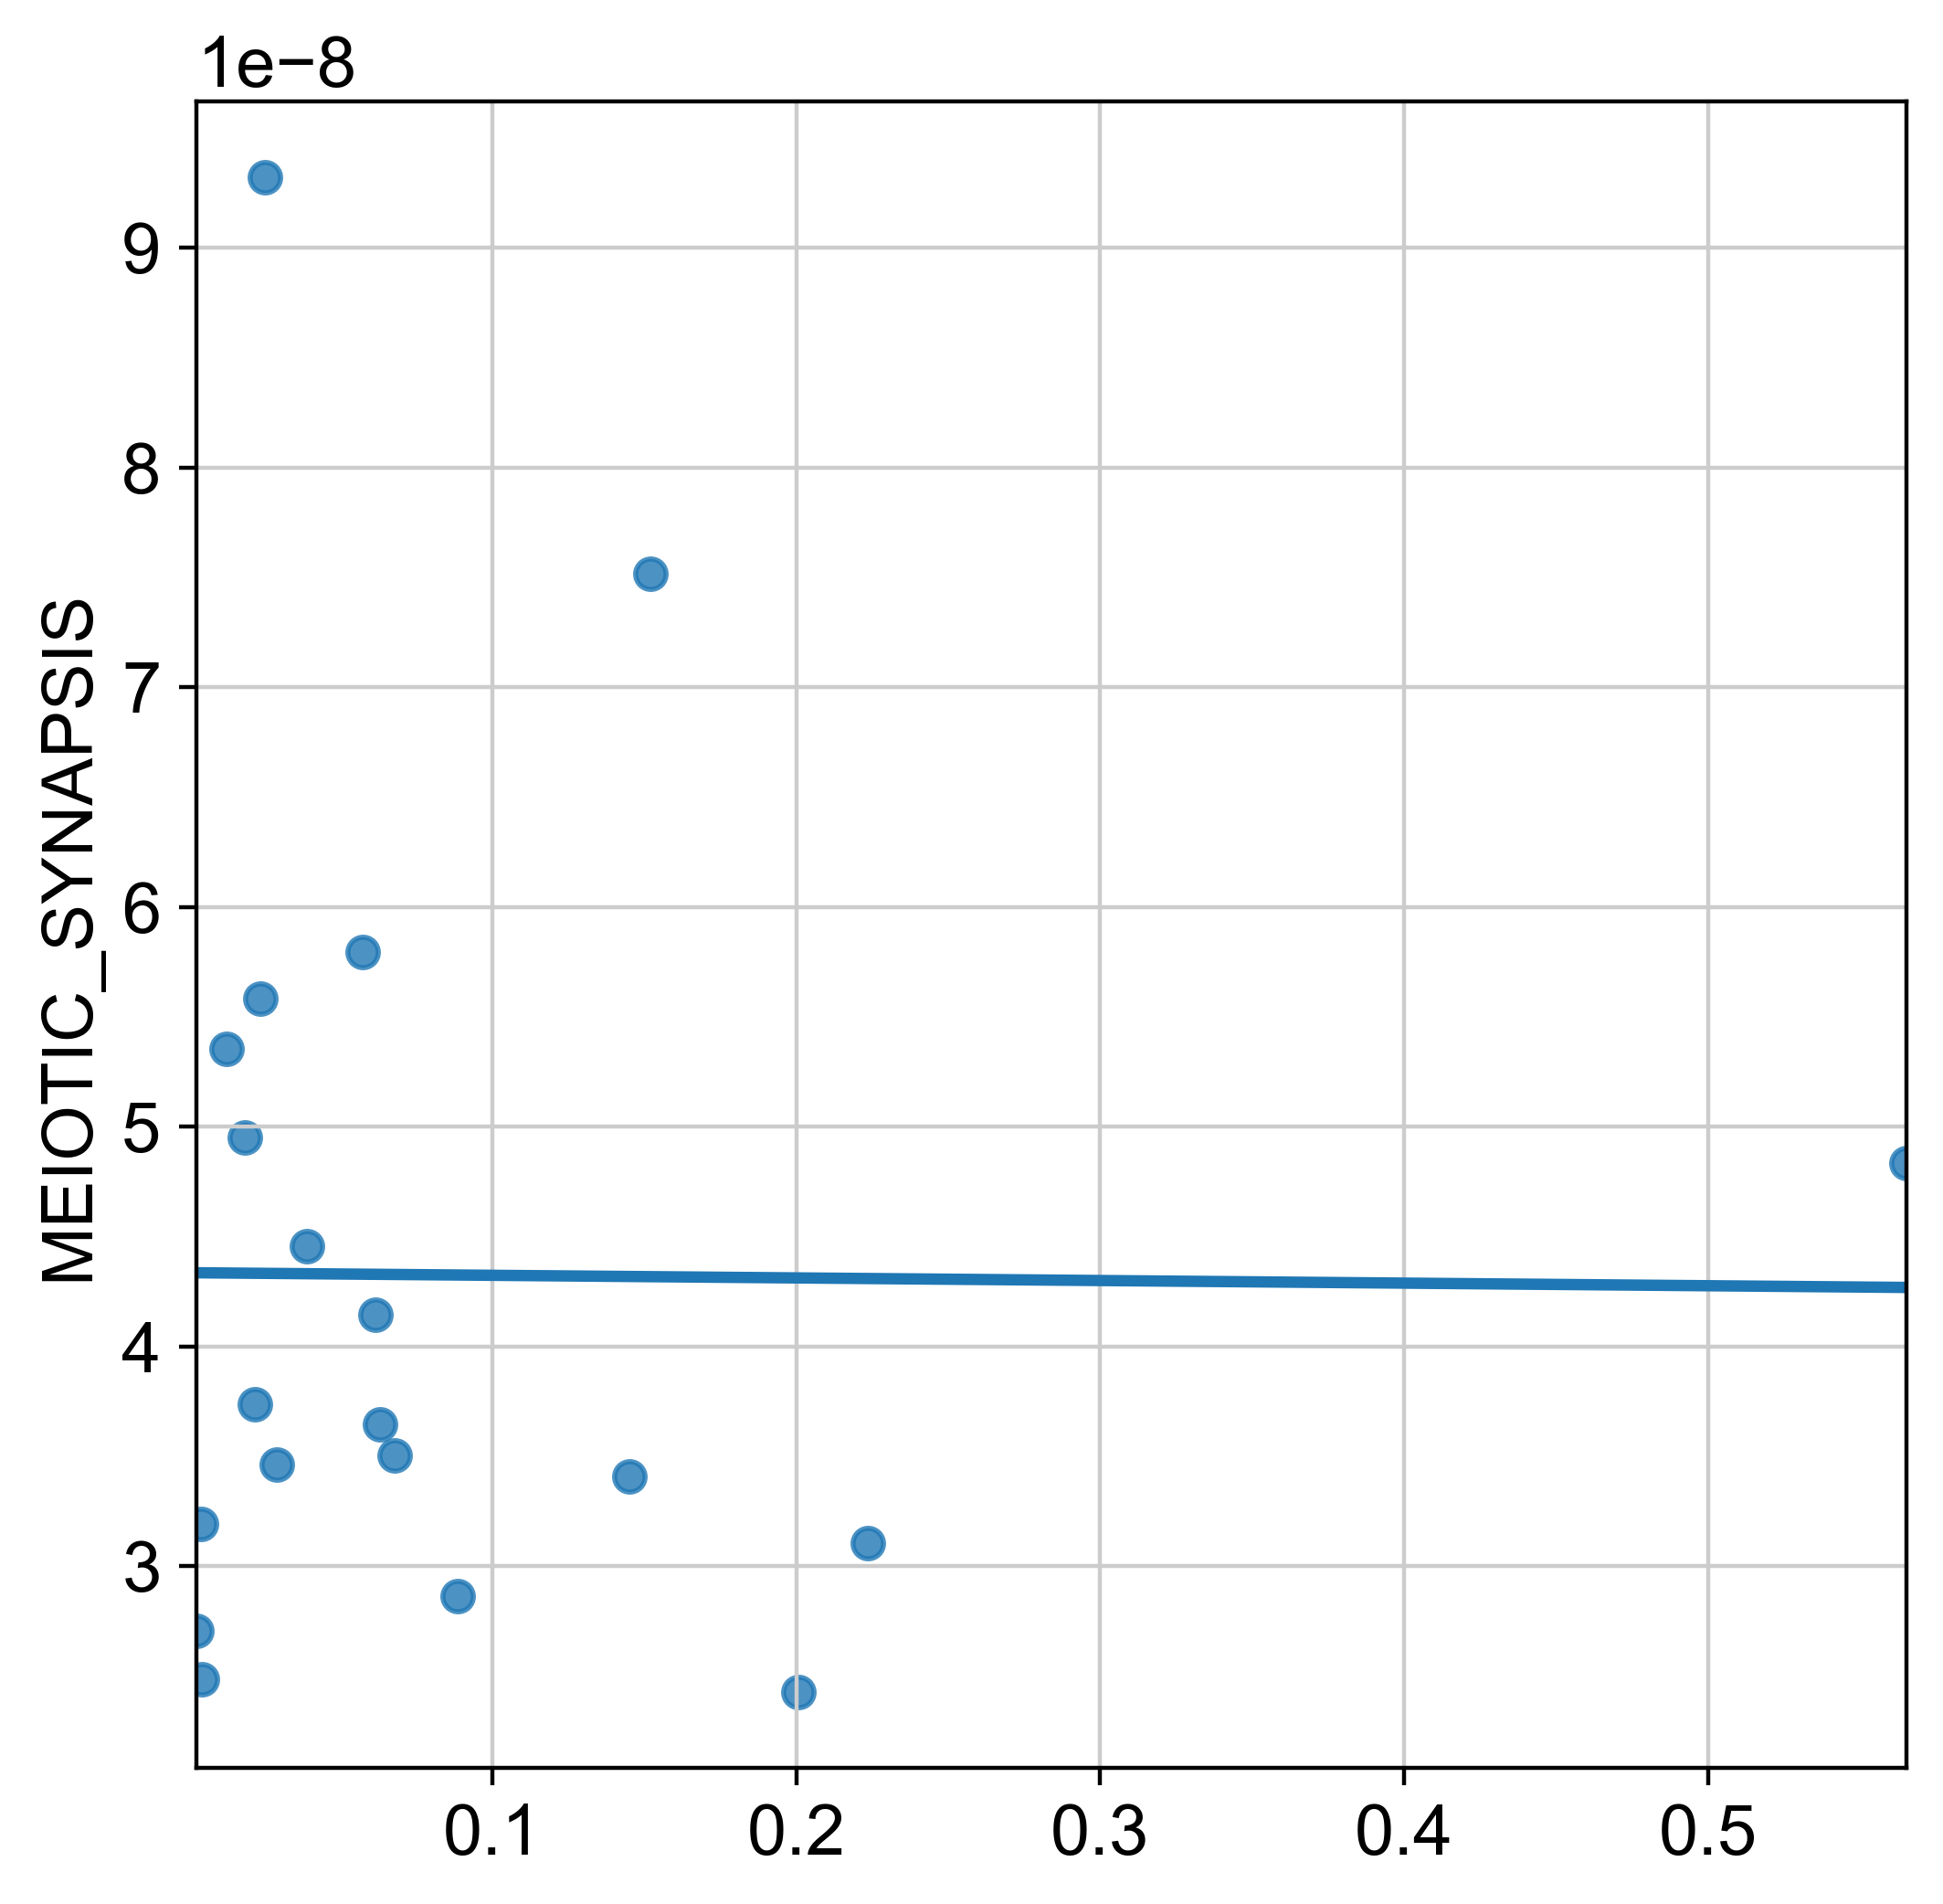

In [38]:
x = np.array(adata[:, tables[12].iloc[:20, 0].index].X.mean(0))
sns.regplot(x=x, y=tables[12].iloc[:20, 0].abs(), ci=None)